In [2]:
# Import all packages will be ued
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
import time
import pickle
import collections
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from skimage.feature import hog
from sklearn.utils import shuffle
from scipy.ndimage.measurements import label
from moviepy.editor import VideoFileClip
from IPython.display import HTML
from lesson_functions import *


%matplotlib inline

### Read all data

In [3]:
# Since the GTI folders contain time_series data, I will manually separate images under different folder.
# That's why I don't combine all car_images and simply split them

print('Reading and splitting data\n')

car_gti_far = glob.glob('./training_images/vehicles/GTI_Far/*.png')
car_gti_left = glob.glob('./training_images/vehicles/GTI_Left/*.png')
car_gti_mid = glob.glob('./training_images/vehicles/GTI_MiddleClose/*.png')
car_gti_right = glob.glob('./training_images/vehicles/GTI_Right/*.png')
car_kitti = glob.glob('./training_images/vehicles/KITTI_extracted/*.png')

# There is no time-series issue regarding to the non_vehicles dataset, so I can combine all non_vehicle dataset
notcar = glob.glob('./training_images/non-vehicles/Extras/*.png')
notcar += glob.glob('./training_images/non-vehicles/GTI/*.png')

# Split 80% training and 20% test
# Mannuly pick first 80% of car_images from GTI dataset as training
fraction = 0.8
L0 = int(fraction*len(car_gti_far)) 
L1 = int(fraction*len(car_gti_left))
L2 = int(fraction*len(car_gti_mid))
L3 = int(fraction*len(car_gti_right)) 
car_train = car_gti_far[:L0] + car_gti_left[:L1] + car_gti_mid[:L2] + car_gti_right[:L3]
car_test = car_gti_far[L0:] + car_gti_left[L1:] + car_gti_mid[L2:] + car_gti_right[L3:]

# car images from KITTI and notcar images can be split using train_test_split
rand_state = np.random.randint(0, 100)
car_train_kitti, car_test_kitti = train_test_split(car_kitti, test_size=0.2, random_state=rand_state)
car_train += car_train_kitti
car_test += car_test_kitti

rand_state = np.random.randint(0, 100)
notcar_train, notcar_test= train_test_split(notcar, test_size=0.2, random_state=rand_state)

num_car_train, num_car_test, num_notcar_train, num_notcar_test = len(car_train), len(car_test), len(notcar_train), len(notcar_test)

print('Car training data size: ', num_car_train)
print('Car test data size: ', num_car_test)
print('Notcar training data size: ', num_notcar_train)
print('Notcar test data size: ', num_notcar_test)
if (num_car_train - num_notcar_train)/ num_car_train < 0.1 and (num_car_test - num_notcar_test)/num_car_test < 0.1:
    print('\nSize of dataset are balanced !!!')

Reading and splitting data

Car training data size:  7032
Car test data size:  1760
Notcar training data size:  7174
Notcar test data size:  1794

Size of dataset are balanced !!!


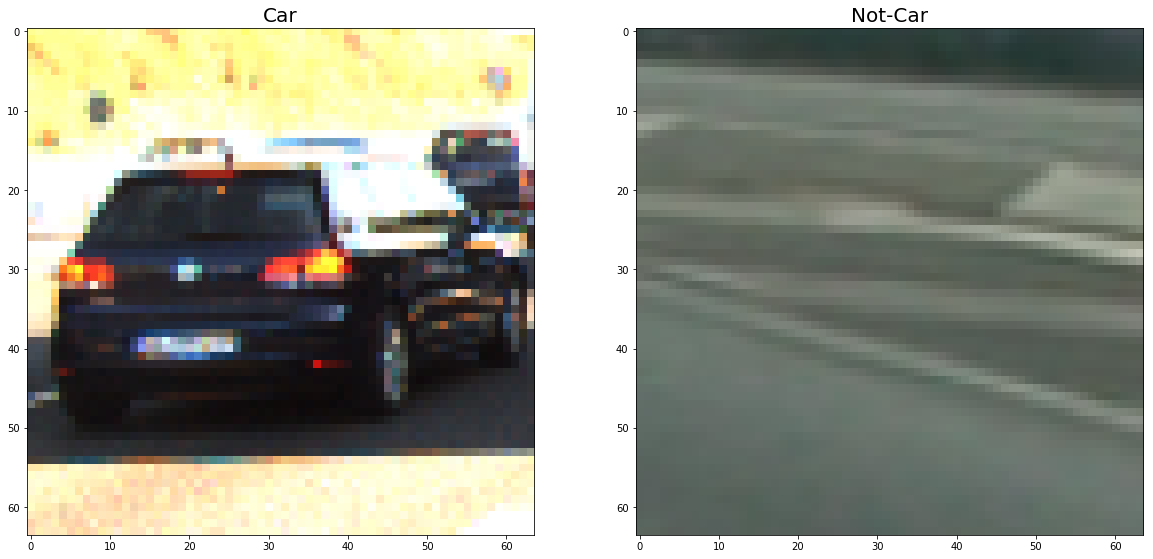

In [4]:
# Randomly choose an image from each of two training sets
idx = np.random.randint(7000)
car_sample = mpimg.imread(car_train[idx])
notcar_sample = mpimg.imread(notcar_train[idx])

# Display
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 10))
ax1.imshow(car_sample)
ax1.set_title('Car', fontsize = 20)
ax2.imshow(notcar_sample)
ax2.set_title('Not-Car', fontsize = 20)
plt.show()
fig.savefig('./output_images/car_notcar_sample.png')

### Training

In [5]:
# Parameters
color_space = 'YCrCb' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 9  # HOG orientations
pix_per_cell = 8 # HOG pixels per cell
cell_per_block = 2 # HOG cells per block
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
spatial_size = (32, 32) # Spatial binning dimensions
hist_bins = 32    # Number of histogram bins
spatial_feat = True # Spatial features on or off
hist_feat = True # Histogram features on or off
hog_feat = True # HOG features on or off



In [6]:
# Use the extract_features() function from lesson_functions to get all training_features
start = time.time()
car_train_features = extract_features(car_train, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

car_test_features = extract_features(car_test, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_train_features = extract_features(notcar_train, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)

notcar_test_features = extract_features(notcar_test, color_space=color_space, 
                        spatial_size=spatial_size, hist_bins=hist_bins, 
                        orient=orient, pix_per_cell=pix_per_cell, 
                        cell_per_block=cell_per_block, 
                        hog_channel=hog_channel, spatial_feat=spatial_feat, 
                        hist_feat=hist_feat, hog_feat=hog_feat)
end = time.time()

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(car_train_features[0]))
print(round(end-start, 2), 'Seconds to extract all features...')



Using: 9 orientations 8 pixels per cell and 2 cells per block
Feature vector length: 8460
130.67 Seconds to extract all features...


In [7]:
# Normalization
X = np.vstack((car_train_features, car_test_features, notcar_train_features, notcar_test_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Split X
car_train_features = scaled_X[:num_car_train]
car_test_features = scaled_X[num_car_train:num_car_train+num_car_test]
notcar_train_features = scaled_X[num_car_train+num_car_test:num_car_train+num_car_test+num_notcar_train]
notcar_test_features = scaled_X[num_car_train+num_car_test+num_notcar_train:]

# Building training data and training labels
X_train = np.vstack((car_train_features, notcar_train_features))
y_train = np.hstack((np.ones(num_car_train), np.zeros(num_notcar_train)))
rand_state = np.random.randint(0, 100)
X_train, y_train = shuffle(X_train, y_train, random_state = rand_state)

X_test = np.vstack((car_test_features, notcar_test_features))
y_test = np.hstack((np.ones(num_car_test), np.zeros(num_notcar_test)))
rand_state = np.random.randint(0, 100)
X_test, y_test = shuffle(X_test, y_test, random_state = rand_state)

In [8]:
# Save data for future use
pickle_file = 'data.p'
print('Saving data to pickle file...')
try:
    with open(pickle_file, 'wb') as pfile:
        pickle.dump(
            {
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test                
            },
            pfile, pickle.HIGHEST_PROTOCOL)
except:
    print('Unable to save data to', pickle_file)
    
# Load the training validation and test data
data_file = 'data.p'
with open(data_file, mode='rb') as f:
    data = pickle.load(f)
X_train = data['X_train']
X_test = data['X_test']
y_train = data['y_train']
y_test = data['y_test']

Saving data to pickle file...


In [9]:
# Use linear SVC as classifier
clf = LinearSVC()

start = time.time()
clf.fit(X_train, y_train)
end = time.time()
print(round(end-start, 2), 'Seconds to train SVC...')

# Check the score of the SVC
print('Test Accuracy of SVC = ', round(clf.score(X_test, y_test), 4))

25.68 Seconds to train SVC...
Test Accuracy of SVC =  0.9854


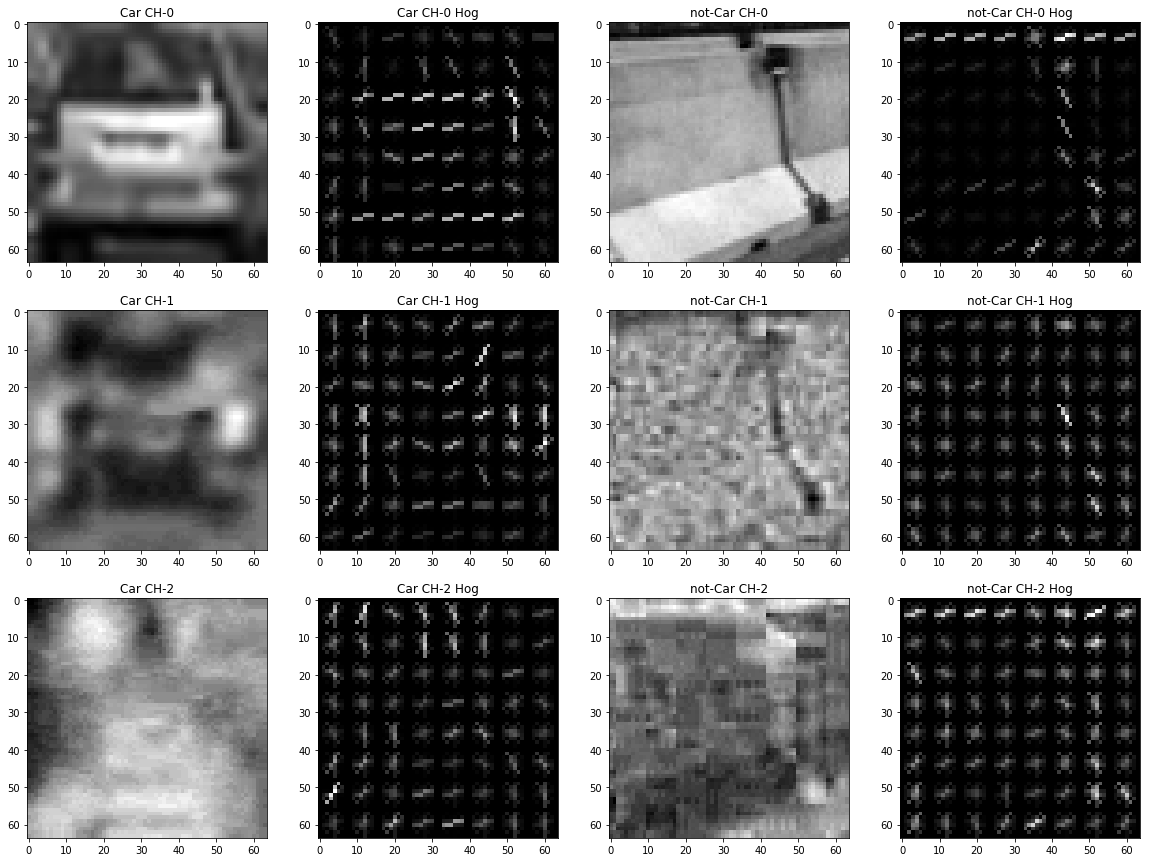

In [10]:
# Randomly pick a car and a not_car images and display its hog features
idx = np.random.randint(0, 1000)
fig, axs = plt.subplots(3, 4, figsize = (20,15))

car_image = mpimg.imread(car_train[idx])
notcar_image = mpimg.imread(notcar_train[idx])

for channel in range(3):
    feature_car_image = cv2.cvtColor(car_image, cv2.COLOR_RGB2YCrCb)
    features_car, hog_image_car = get_hog_features(feature_car_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    axs[channel, 0].imshow(feature_car_image[:,:,channel], cmap = 'gray')
    axs[channel, 0].set_title('Car CH-{}'.format(channel), fontsize = 12)
    axs[channel, 1].imshow(hog_image_car, cmap = 'gray')
    axs[channel, 1].set_title('Car CH-{} Hog'.format(channel), fontsize = 12)
    
    feature_notcar_image = cv2.cvtColor(notcar_image, cv2.COLOR_RGB2YCrCb)
    features_notcar, hog_image_notcar = get_hog_features(feature_notcar_image[:,:,channel], orient, pix_per_cell, cell_per_block, vis=True, feature_vec=True)
    axs[channel, 2].imshow(feature_notcar_image[:,:,channel], cmap = 'gray')
    axs[channel, 2].set_title('not-Car CH-{}'.format(channel), fontsize = 12)
    axs[channel, 3].imshow(hog_image_notcar, cmap = 'gray')
    axs[channel, 3].set_title('not-Car CH-{} Hog'.format(channel), fontsize = 12)
    
plt.show()

# Save for writeup
fig.savefig('./output_images/car_hog.png')

### Sliding window

In [11]:
# Multi_scale windows
def multiple_scale_windows(img):
    num_scale = 4
    xy_overlap = [[0.75,0.75],[0.75,0.75],[0.75,0.75],[0.75,0.75]]
    xy_window = [[64,64], [96,96], [128,128],[160,160]]
    x_start_stop = [[None, None],[None, None],[None, None],[None, None]]
    y_start_stop = [[400,400 + xy_window[0][0]*2], [400, 400 + xy_window[1][0]*2], [400, 400 + xy_window[2][0]*2], [400,None]]
    
    all_windows = []
    for i in range(num_scale):
        cur_windows = slide_window(img, x_start_stop[i], y_start_stop[i], xy_window[i], xy_overlap[i])
        all_windows += [cur_windows]
    return all_windows



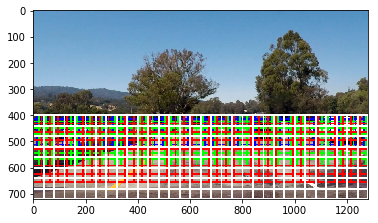

In [12]:
# Draw windows on test images
test_image = mpimg.imread('./test_images/test1.jpg')
windows = multiple_scale_windows(test_image)
window_img = test_image
for i in range(4):
    if i==0: color= (0,0,255)
    if i==1: color= (0,255,0)
    if i==2: color= (255,0,0)
    if i==3: color= (255,255,255)
    window_img = draw_boxes(window_img, windows[i], color=color, thick=6)
plt.imshow(window_img)
plt.savefig('./output_images/windows.png')

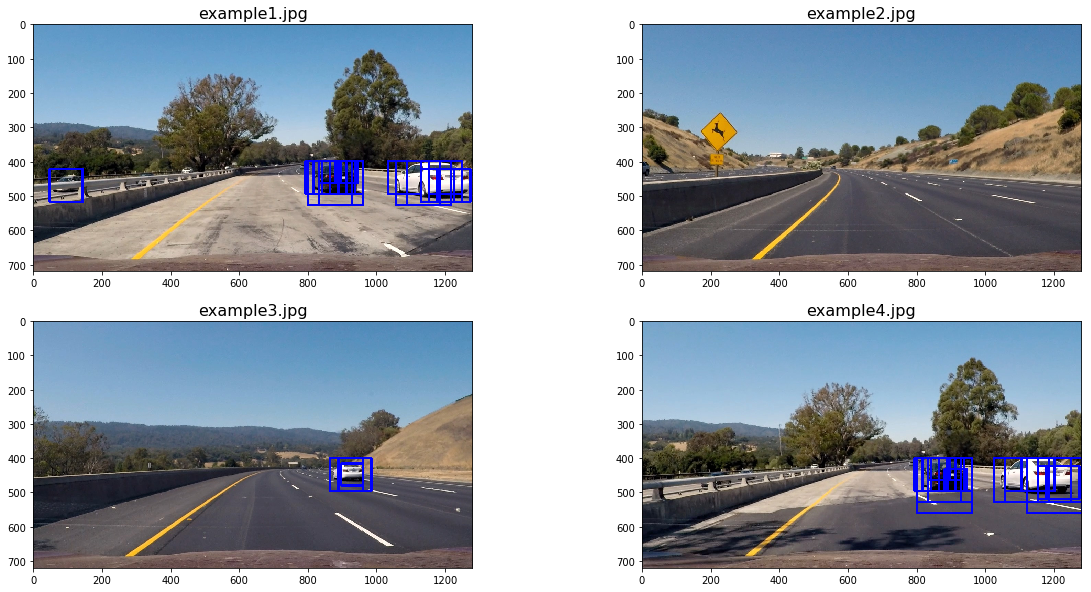

In [13]:
# Flatten the windows
all_windows = []
for window in windows:
    all_windows.extend(window)

# Find hotwindows on test images
fig, axs = plt.subplots(2, 2, figsize = (20,10))
axs = axs.ravel()
for i in range(4):
    test_image = mpimg.imread('./test_images/test{}.jpg'.format(i+1))
    # All training are using .png so need to scale (0,255) to (0,1)
    test_image = test_image.astype(np.float32)/255
        
    hot_windows = search_windows(test_image, all_windows, clf, X_scaler, color_space=color_space, 
                  spatial_size=spatial_size, hist_bins=hist_bins, 
                  orient=orient, pix_per_cell=pix_per_cell, 
                  cell_per_block=cell_per_block, 
                  hog_channel=hog_channel, spatial_feat=spatial_feat, 
                  hist_feat=hist_feat, hog_feat=hog_feat)  

    
    window_img = draw_boxes(test_image, hot_windows, color=(0, 0, 1), thick=6)  
    axs[i].imshow(window_img)
    axs[i].set_title('example{}.jpg'.format(i+1),fontsize = 16)

plt.show()
fig.savefig('./output_images/hot_windows')

### Video Pipeline

In [14]:
# Record test_videos
vidcap = cv2.VideoCapture('test_video.mp4')
count = 0
success = True
while success:
    success,image = vidcap.read()
    if success:
        cv2.imwrite('./test_video_frames/frame{}.jpg'.format(count), image)     # save frame as JPEG file
        count += 1

In [15]:
# Define a class to receive the boxes
class boxes():
    # Every frame will take previous 6(self included) into account by default
    def __init__(self, n=6):
        self.stored_boxes = collections.deque(maxlen = 6)
        self.all_boxes = None
    
    def get_all_boxes(self):
        all_boxes = []
        for hot_box in self.stored_boxes:
            all_boxes.extend(hot_box)
        return all_boxes
    
    def add_boxes(self, hot_windows):
        self.stored_boxes.append(hot_windows)

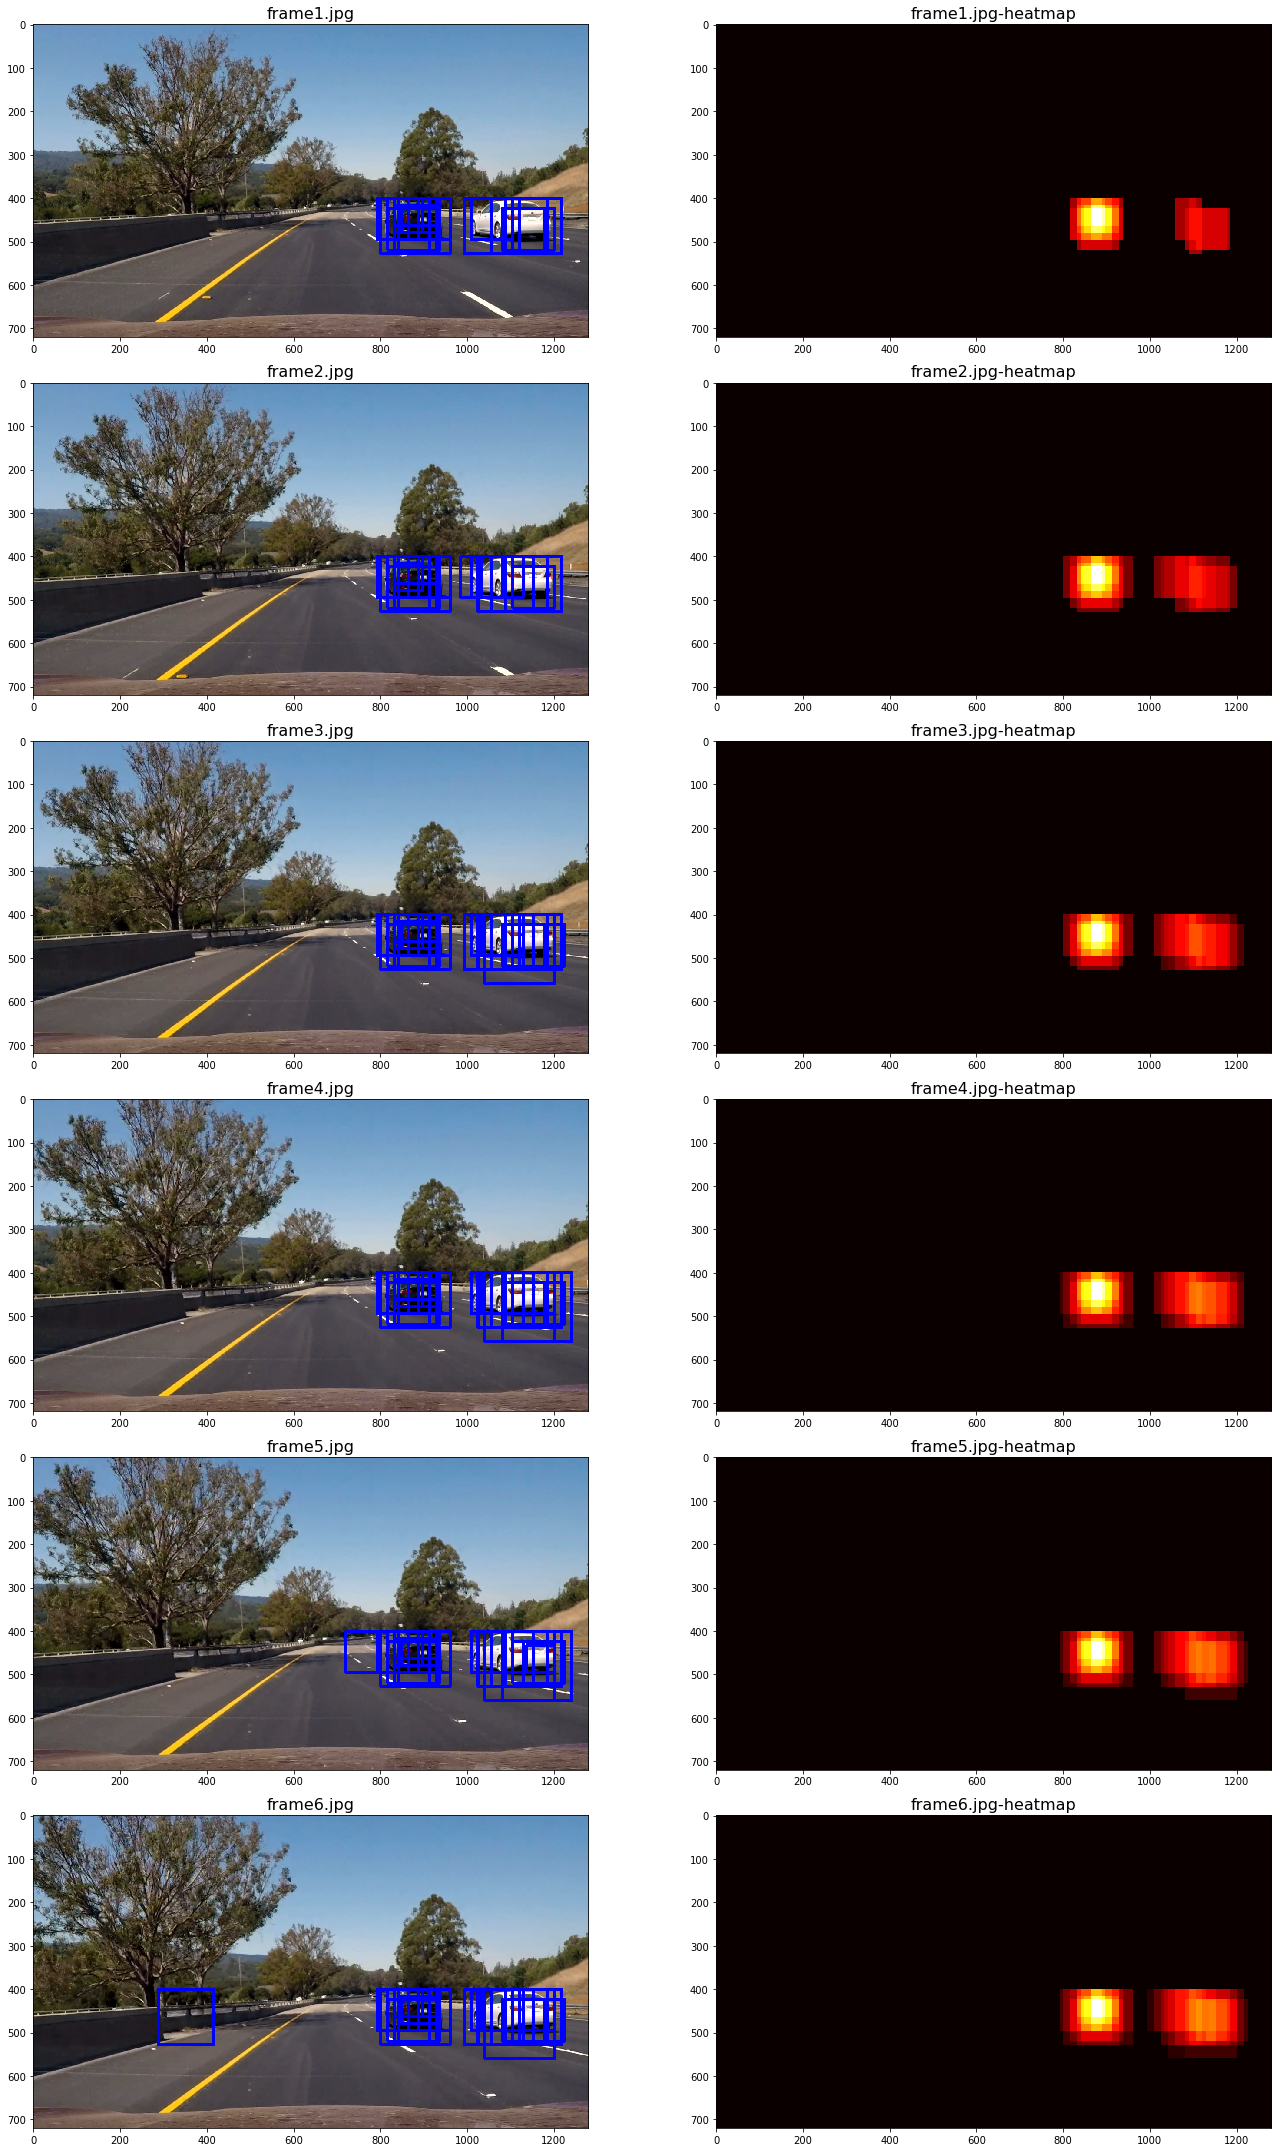

In [16]:
# Heatmap
heat_images = []
for i in range(1,7):
    heat_images.append('./test_video_frames/frame{}.jpg'.format(i))

box = boxes()

fig, axs = plt.subplots(6, 2, figsize=(20,30))
for i, file_name in enumerate(heat_images):
    heat_img = mpimg.imread(file_name)
    heat_img = heat_img.astype(np.float32)/255
    
    hot_windows = search_windows(heat_img, all_windows, clf, X_scaler, color_space=color_space, 
                  spatial_size=spatial_size, hist_bins=hist_bins, 
                  orient=orient, pix_per_cell=pix_per_cell, 
                  cell_per_block=cell_per_block, 
                  hog_channel=hog_channel, spatial_feat=spatial_feat, 
                  hist_feat=hist_feat, hog_feat=hog_feat) 
    
    box.add_boxes(hot_windows)
    
    window_img = draw_boxes(heat_img, hot_windows, color=(0, 0, 1), thick=6)  
    axs[i,0].imshow(window_img)
    axs[i,0].set_title(file_name.split('/')[-1], fontsize = 16)
    

    heat = np.zeros_like(heat_img[:,:,0]).astype(np.float)
    
    all_boxes = box.get_all_boxes()
    # Add heat to each box in box list 
    heat = add_heat(heat, all_boxes)
    # Apply threshold to help remove false positives
    num_frames = len(box.stored_boxes)
    # Set threshold
    heat = apply_threshold(heat,min(3,num_frames+1))
    heatmap = np.clip(heat, 0, 255)
    
    axs[i,1].imshow(heatmap, cmap='hot')
    axs[i,1].set_title(file_name.split('/')[-1] + '-heatmap', fontsize = 16)

plt.tight_layout()
plt.show()
fig.savefig('./output_images/heatmap')

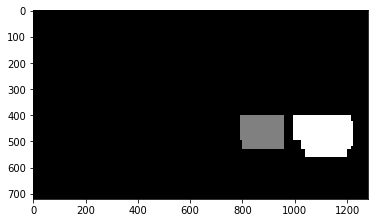

In [17]:
# Output of scipy.ndimage.measurements.label() on the integrated heatmap from all 6 frames
labels = label(heatmap)
plt.imshow(labels[0], cmap='gray')
plt.savefig('./output_images/gray_label')

2 cars detected


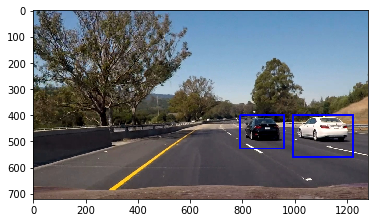

In [18]:
heat_img = mpimg.imread(heat_images[-1])
draw_img = draw_labeled_bboxes(np.copy(heat_img), labels)
print('{} cars detected'.format(labels[1]))
plt.imshow(draw_img)
plt.savefig('./output_images/final_image')

In [19]:
def pipeline(img):
    # Make a copy of original jpg image for draw_labeled_bboxes
    draw_img = np.copy(img)
    
    # Training was done on .png which scaled (0,1)
    img = img.astype(np.float32)/255
    
    # Search hot windows
    hot_windows = search_windows(img, all_windows, clf, X_scaler, color_space=color_space, 
                  spatial_size=spatial_size, hist_bins=hist_bins, 
                  orient=orient, pix_per_cell=pix_per_cell, 
                  cell_per_block=cell_per_block, 
                  hog_channel=hog_channel, spatial_feat=spatial_feat, 
                  hist_feat=hist_feat, hog_feat=hog_feat) 
    
    
    # Get hot_windows from previous 6 frames
    box.add_boxes(hot_windows)
    all_boxes = box.get_all_boxes()
    
    # Get heatmap
    heat = np.zeros_like(heat_img[:,:,0]).astype(np.float)
    heat = add_heat(heat, all_boxes)
    num_frames = len(box.stored_boxes)
    heat = apply_threshold(heat,min(3,num_frames+1))
    heatmap = np.clip(heat, 0, 255)
    
    # Draw boxes
    labels = label(heatmap)
    output_img = draw_labeled_bboxes(draw_img, labels)
    
    return output_img

In [374]:
# Produce video
box = boxes()
outdir = './output_images/processed_project_video.mp4'
video_input = VideoFileClip('project_video.mp4')
out_clip = video_input.fl_image(pipeline) 
%time out_clip.write_videofile(outdir, audio=False)

[MoviePy] >>>> Building video ./output_images/processed_project_video.mp4
[MoviePy] Writing video ./output_images/processed_project_video.mp4



100%|█████████▉| 1260/1261 [2:09:34<00:06,  6.20s/it] 


[MoviePy] Done.
[MoviePy] >>>> Video ready: ./output_images/processed_project_video.mp4 

CPU times: user 2h 9min 14s, sys: 18.7 s, total: 2h 9min 33s
Wall time: 2h 9min 35s
